In [7]:
# Load libraries
import pandas as pd
import numpy as np
import scipy.io as sp
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Activation
from keras.layers import Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn import preprocessing


In [2]:
########################################################
################ Load 7m/s cases ########################
########################################################

mat1 = np.load('data/dataset_7_9_ms_007_010_ti.npy')
mat2 = np.load('data/7_9ms_ti_IA.npy')

Case1_7ms = pd.DataFrame({'WS':[], 'Power': []})
Case2_7ms = pd.DataFrame({'WS':[], 'Power': []})
Case3_7ms = pd.DataFrame({'WS':[], 'Power': []})
for i in range(1,13,2):    
    A1 = pd.DataFrame({'WS': mat1[:,i], 'Power': mat1[:,i+1]})
    Case1_7ms = pd.concat([Case1_7ms, A1], ignore_index=True)
    A2 = pd.DataFrame({'WS': mat1[:,i+12], 'Power': mat1[:,i+12+1]})
    Case2_7ms = pd.concat([Case2_7ms, A2], ignore_index=True)
    A3 = pd.DataFrame({'WS': mat2[:,i], 'Power': mat2[:,i+1]})
    Case3_7ms = pd.concat([Case3_7ms, A3], ignore_index=True)


########################################################
################ Load 9m/s cases ########################
########################################################

Case1_9ms = pd.DataFrame({'WS':[], 'Power': []})
Case2_9ms = pd.DataFrame({'WS':[], 'Power': []})
Case3_9ms = pd.DataFrame({'WS':[], 'Power': []})
for i in range(1,13,2):    
    A3 = pd.DataFrame({'WS': mat1[:,i+2*12], 'Power': mat1[:,i+2*12+1]})
    Case1_9ms = pd.concat([Case1_9ms, A3], ignore_index=True)
    A4 = pd.DataFrame({'WS': mat1[:,i+3*12], 'Power': mat1[:,i+3*12+1]})
    Case2_9ms = pd.concat([Case2_9ms, A4], ignore_index=True)
    A5 = pd.DataFrame({'WS': mat2[:,i+12], 'Power': mat2[:,i+12+1]})
    Case3_9ms = pd.concat([Case3_9ms, A5], ignore_index=True)
    
    
########################################################
############### Load 11m/s cases ########################
########################################################

mat3 = np.load('data/11ms_ti_07_10_IA.npy')
Case1_11ms = pd.DataFrame({'WS':[], 'Power': []})
Case2_11ms = pd.DataFrame({'WS':[], 'Power': []})
Case3_11ms = pd.DataFrame({'WS':[], 'Power': []})
for i in range(1,13,2):    
    A1 = pd.DataFrame({'WS': mat3[:,i], 'Power': mat3[:,i+1]})
    Case1_11ms = pd.concat([Case1_11ms, A1], ignore_index=True)
    A2 = pd.DataFrame({'WS': mat3[:,i+12], 'Power': mat3[:,i+12+1]})
    Case2_11ms = pd.concat([Case2_11ms, A2], ignore_index=True)
    A3 = pd.DataFrame({'WS': mat3[:,i+2*12], 'Power': mat3[:,i+2*12+1]})
    Case3_11ms = pd.concat([Case3_11ms, A3], ignore_index=True)
    

In [3]:
################################################################
### Convert indices to datetime (always easier to manipulate)###
################## 100Hz sampling ##############################
index = pd.date_range('1/1/2019', periods=len(Case2_9ms['WS']), freq='10ms')
Case2_9ms.index = index

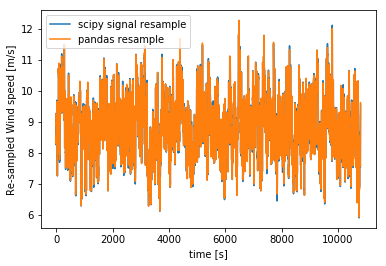

         WS         Power
0  9.183920  4.639830e+06
1  8.257285  5.381061e+06
2  8.371866  5.254845e+06
3  8.477866  5.403649e+06
4  9.102787  5.282126e+06
             WS         Power
10795  8.858442  3.983978e+06
10796  8.947147  3.988048e+06
10797  9.176362  3.920286e+06
10798  9.308008  4.073257e+06
10799  9.559261  3.844209e+06


In [4]:
#########################################################################
############ Resample the dataset for training & validation #############
#########################################################################
from scipy import signal
res_freq = int(len(Case2_9ms['WS'])/100)
Case2_9ms_resampled1 = pd.DataFrame({'WS': signal.resample(Case2_9ms['WS'], res_freq), 
                                'Power': signal.resample(Case2_9ms['Power'], res_freq)})

Case2_9ms_resampled2 = Case2_9ms.resample('S').mean()
plt.plot(Case2_9ms_resampled1['WS'].values, label='scipy signal resample')
plt.plot(Case2_9ms_resampled2['WS'].values, label='pandas resample')
plt.ylabel('Re-sampled Wind speed [m/s]')
plt.xlabel('time [s]')
plt.legend()
plt.show()

Case2_9ms_resampled = Case2_9ms_resampled1
print(Case2_9ms_resampled.head())
print(Case2_9ms_resampled.tail())

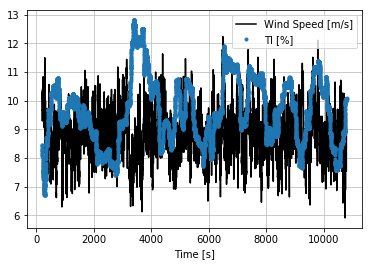

In [6]:
#########################################################################
########## Estimate "moving TI" using high freq. WS simulations #########
#########################################################################
stdWS_1 = Case2_9ms_resampled['WS'].rolling(window = 600, min_periods=1).std() # rolling std over 10min to include the dynamics "better"
# Clear 'unstable' std_WS samples (about 100 samples for Case2)
stdWS_1 = stdWS_1.iloc[100:]
TI_1 = stdWS_1/Case2_9ms_resampled['WS'].rolling(window = 600, min_periods=1).mean()*100
TI_1 = TI_1.iloc[100:]
Case2_9ms_resampled = Case2_9ms_resampled.iloc[100:]

f,ax = plt.subplots(ncols=1, nrows=1)
ax.plot(Case2_9ms_resampled['WS'],'k', label='Wind Speed [m/s]')
ax.plot(TI_1,'.',label = 'TI [%]')
plt.xlabel('Time [s]')
plt.legend()
ax.grid(b=True, which='major', color='silver', linestyle='-')
plt.show()


In [8]:
####################################################################
################ Prepare dataset for LSTM problem ##################
####################################################################

import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.externals import joblib


### define a function that will split the sequences to input and output of the training
def series_to_forecast(data, n_in, n_out, dropnan=True):
    """
    A function that will split the time series to input and output for training 
    of the forecast problem with supervised learning
    Arguments:
        data: Sequence of observations as a list, NumPy array or pandas series
        n_in: Number of lag observations as input (X).
        n_out: Number of observations as output (y).
        dropnan: Boolean whether or not to drop rows with NaN values.
    Returns:
        Pandas DataFrame of series framed for supervised learning.
    """
    n_vars = data.shape[1] 
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together (aggregate)
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

# bring the functions together for compact prepare data function
def prepare_data(scaled_values, n_lag, n_seq):
    """
    A function that combines differencing and scaling. Prepares the data for robust LSTM training.
    Arguments:
        series: time series to be prepared for training
        n_lag: number of previous hourly time steps to use for training
        n_seq: forecast horizon [h] 
    Returns:
        Pandas DataFrame of quasi-stationary time series framed for supervised learning.
    """
    # transform into supervised learning problem X, y
    supervised = series_to_forecast(scaled_values, n_lag, n_seq)
    supervised_values = supervised.values
    return supervised_values

### Split data into train & test 
train_int = np.int(0.6*len(Case2_9ms_resampled['WS']))

### training input vector
U_train_in = Case2_9ms_resampled['WS'][1:train_int]
# U_train_in = WS_1[1:train_int+1]
std_train_in = stdWS_1[1:train_int]
Power_train_in = np.array(Case2_9ms_resampled['Power'][1:train_int])

X_train = pd.DataFrame(data=np.column_stack((U_train_in, std_train_in)))
Y_train = pd.DataFrame(Power_train_in)          

### validation input vector
U_test_in = Case2_9ms_resampled['WS'][train_int:-17]
# U_test_in = Case2_resampled['WS'][train_int:]
std_test_in = stdWS_1[train_int:-17]
Power_test_in = np.array(Case2_9ms_resampled['Power'][train_int:-17])

X_validation = pd.DataFrame(data=np.column_stack((U_test_in, std_test_in)))
Y_validation = pd.DataFrame(Power_test_in)      

n_in = 29 # number of previous time steps to use for training, a.k.a. time-lag
n_out = 1  # forecast horizon [s] 

### scale the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
X_train_scaled = scaler.fit_transform(X_train)
X_validation_scaled = scaler.transform(X_validation)
X_scaler = scaler
X_scaler_filename = 'X_scaler_org.save'
joblib.dump(X_scaler, X_scaler_filename)

Y_train_scaled = scaler.fit_transform(Y_train)
Y_validation_scaled = scaler.transform(Y_validation)
Y_scaler = scaler
Y_scaler_filename = 'Y_scaler_org.save'
joblib.dump(Y_scaler, Y_scaler_filename)

### frame dataset for LSTM with lags
X_train_framed = prepare_data(X_train_scaled, n_in, n_out)
X_validation_framed = prepare_data(X_validation_scaled, n_in, n_out)
Y_train_framed = Y_train_scaled[n_in:]
Y_validation_framed = Y_validation_scaled[n_in:]


print('Training input (samples, timesteps):', X_train_framed.shape)
print('Training output (samples, timesteps):', Y_train_framed.shape)
print('Validation input (samples, timesteps):', X_validation_framed.shape)
print('Training output (samples, timesteps):', Y_validation_framed.shape)



Training input (samples, timesteps): (6330, 60)
Training output (samples, timesteps): (6330, 1)
Validation input (samples, timesteps): (4194, 60)
Training output (samples, timesteps): (4194, 1)


In [9]:
#########################################################################
### Transfer the model from Case1 to further train with Case2 dataset ###
#########################################################################

### Input : Incoming WS and TI to the turbine
### Output : (Active) Power of the turbine

from keras.models import load_model
from keras import layers

First_LSTM = load_model('First_LSTM_network.h5')
First_LSTM.summary()

len(First_LSTM.layers)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 30, 100)           41200     
_________________________________________________________________
activation_1 (Activation)    (None, 30, 100)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 30, 100)           80400     
_________________________________________________________________
activation_2 (Activation)    (None, 30, 100)           0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 40)                22560     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 41        
Total params: 144,201
Trainable params: 144,201
Non-trainable params: 0
_________________________________________________________________


6

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1_input (InputLayer)    (None, 30, 2)             0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 30, 100)           41200     
_________________________________________________________________
activation_1 (Activation)    (None, 30, 100)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 30, 100)           80400     
_________________________________________________________________
activation_2 (Activation)    (None, 30, 100)           0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 40)                22560     
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 41        
Total para

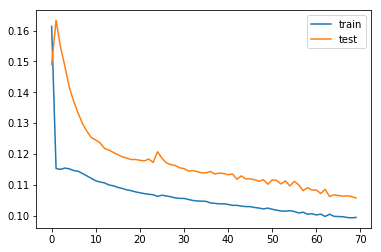

Wall time: 5min 52s


In [12]:
%%time

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Activation
from keras.utils import plot_model 
from keras.models import Model 
from keras.layers import Input, Dropout, Flatten, Dense, GlobalAveragePooling2D
from keras.utils import plot_model 
#from keras.callbacks import TensorBoard
#import keras.backend as K

# reshape input to be 3D [samples, timesteps, features] -- expected by LSTM
train_X = X_train_framed.reshape((X_train_framed.shape[0], n_in+1, 2))
test_X = X_validation_framed.reshape((X_validation_framed.shape[0], n_in+1, 2))
train_y = (Y_train_framed)
test_y = (Y_validation_framed)

# # Freeze the layers which you don't want to train in the pre-trained model
for layer in First_LSTM.layers[:4]:
     layer.trainable = False

x = LSTM(40, activation='tanh')(First_LSTM.layers[-3].output)
outputs = Dense(1)(x)
model_transfer = Model(First_LSTM.input, outputs)

##### Designing network #######
n_batch = 60 

model_transfer.compile(loss='mean_absolute_error', optimizer='adam')
model_transfer.summary()
### fit network
history = model_transfer.fit(train_X, train_y,
                    epochs = 70, 
                    batch_size=n_batch, 
                    validation_data=(test_X, test_y), 
                    verbose=2, 
                    shuffle=False)
### plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

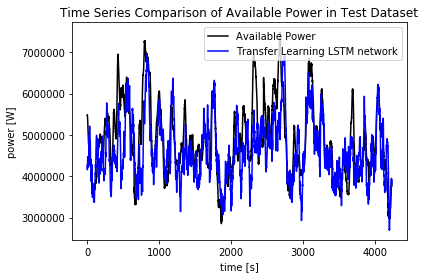

In [15]:
####### make a prediction ##########
yhat_l = list()
y_l = list()

yhat = model_transfer.predict(test_X, batch_size=n_batch)
### invert scaling for prediction
inv_yhat = scaler.inverse_transform(yhat)
### invert scaling for actual
inv_y = scaler.inverse_transform(test_y)
inv_y = inv_y[:,0]
yhat_l.extend(inv_yhat)
y_l.extend(inv_y) 
### Simple plot for comparison on the test dataset
y_ar = np.asarray(y_l)
yhat_ar = np.asarray(yhat_l)
plt.plot(y_ar, 'k', label='Available Power')
plt.plot(yhat_ar,'b',label='Transfer Learning LSTM network')
plt.xlabel('time [s]')
plt.ylabel('power [W]')
plt.legend()
plt.title('Time Series Comparison of Available Power in Test Dataset')
plt.show()

In [16]:
#### save the model ########
model_transfer.save('Transfer_Learning_LSTM_network.h5')  # creates a HDF5 file 